In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys 
sys.path.append('..')



In [13]:


from utils.utils import show_mask_image
import matplotlib.pyplot as plt

from data.ddsm_dataset import get_train_dataloader, DDSM_Patch_Dataset

split_csv = '../resources/ddsm/ddsm_nikulin_partitions/train_filenames.txt'


ddsm_annotations = '../resources/ddsm/ddsm_annotations_16bits_2240_1792.json.gz'
root_dir = '/home/alalbiol/Data/mamo/DDSM_png_16bit_2240x1792'

from data.ddsm_dataset import DDSMImageDataModule
from utils.load_config import load_config

config = load_config('../config_files/base_config_image.yaml')

config['Datamodule']['ddsm_root'] = root_dir
print(config['Datamodule'])

{'ddsm_root': '/home/alalbiol/Data/mamo/DDSM_png_16bit_2240x1792', 'train_csv': 'resources/ddsm/ddsm_nikulin_partitions/train_filenames.txt', 'val_csv': 'resources/ddsm/ddsm_nikulin_partitions/valid_filenames.txt', 'ddsm_annotations': 'resources/ddsm/ddsm_annotations_16bits_1152_896.json.gz', 'convert_to_rgb': False, 'return_mask': True, 'batch_size': 24, 'balanced_patches': True, 'num_workers': 32, 'pin_memory': True, 'dream_pilot_folder': '/home/alalbiol/Data/mamo/dream_pilot_png_832x1152'}


In [14]:
dm = DDSMImageDataModule(config)

train_dl = dm.train_dataloader()
train_ds = train_dl.dataset
print("Num images in train dataset: ", len(train_ds))

Number of images in split:  7876
Number of images after assgining labels:  7876  Images without annotations (other breasts in cancer/bening folders):  2715
Using balanced batch sampler
Num images in train dataset:  7876


In [15]:
train_ds.return_mask

True

69309
(2240, 1792)


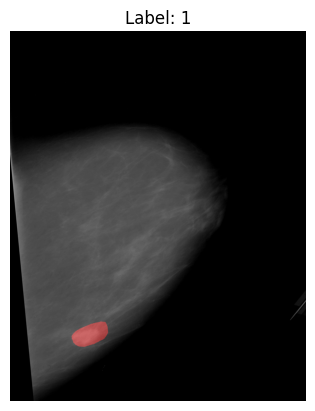

In [16]:
sample = train_ds[4700]
image = sample[0]
label = sample[1]
mask = sample[2]

print(mask.sum())
print(mask.shape)


show_mask_image(image[0], mask*255, title = f"Label: {label}")

In [17]:
from models.model_selector import get_patch_model
import timm
import torch.nn as nn

model_name = 'swin_base_patch4_window7_224'
pretrained = False
num_classes = 7


# model = get_patch_model(model_name, num_classes=5, 
#                         pretrained=False, 
#                         trainable_gray2RGB=True,
#                     )

model = timm.create_model(model_name, pretrained=pretrained)
print(model.state_dict().keys())
model.head.fc = nn.Sequential(nn.Dropout(0.5),
    nn.Linear(model.head.fc.in_features, num_classes)
    )               

from models.modules import Gray2RGBadaptor
model = nn.Sequential(
    Gray2RGBadaptor(), 
    model)


checkpoint_file = '/home/alalbiol/Programacion/Mammography/mamo_holistic/checkpoints/swin_base_x2_224_multilabel_CE_epoch=22-step=4025-val_auroc=0.919.ckpt'
#checkpoint_file = '/home/alalbiol/Programacion/Mammography/mamo_holistic/checkpoints/swin_base_x2_224_multilabel_mixup_0.8_CE_0.0_wd_0.2_dropout_0.5/swin_base_x2_224_CE_epoch=23-step=4200-val_auroc=0.927.ckpt'
checkpoint = torch.load(checkpoint_file, map_location='cpu', weights_only=True)

new_state_dict = {key.replace("model.", ""): value for key, value in checkpoint['state_dict'].items()}


model.load_state_dict(new_state_dict)
print(new_state_dict.keys())
model[1].set_input_size((1120,896))


odict_keys(['patch_embed.proj.weight', 'patch_embed.proj.bias', 'patch_embed.norm.weight', 'patch_embed.norm.bias', 'layers.0.blocks.0.norm1.weight', 'layers.0.blocks.0.norm1.bias', 'layers.0.blocks.0.attn.relative_position_bias_table', 'layers.0.blocks.0.attn.qkv.weight', 'layers.0.blocks.0.attn.qkv.bias', 'layers.0.blocks.0.attn.proj.weight', 'layers.0.blocks.0.attn.proj.bias', 'layers.0.blocks.0.norm2.weight', 'layers.0.blocks.0.norm2.bias', 'layers.0.blocks.0.mlp.fc1.weight', 'layers.0.blocks.0.mlp.fc1.bias', 'layers.0.blocks.0.mlp.fc2.weight', 'layers.0.blocks.0.mlp.fc2.bias', 'layers.0.blocks.1.norm1.weight', 'layers.0.blocks.1.norm1.bias', 'layers.0.blocks.1.attn.relative_position_bias_table', 'layers.0.blocks.1.attn.qkv.weight', 'layers.0.blocks.1.attn.qkv.bias', 'layers.0.blocks.1.attn.proj.weight', 'layers.0.blocks.1.attn.proj.bias', 'layers.0.blocks.1.norm2.weight', 'layers.0.blocks.1.norm2.bias', 'layers.0.blocks.1.mlp.fc1.weight', 'layers.0.blocks.1.mlp.fc1.bias', 'layers.

In [18]:

model = model.to('cuda')
model.eval()
#



Sequential(
  (0): Gray2RGBadaptor(
    (conv): Conv2d(1, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (1): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, ele

In [19]:
torch.cuda.empty_cache() 
x =image.to('cuda')
x =x.unsqueeze(0)
print(x.shape)
x.device

model = model.to('cuda')
model[0].eval()

pooling = nn.AvgPool2d(7, stride=7)

with torch.no_grad():
    xrbg = model[0](x)
    out = model[1].forward_features(xrbg)
    print(out.shape)
    out = out.permute(0,3,1,2)
    out = pooling(out)
    out = out.permute(0,2,3,1)
    out_features = out.cpu().numpy()
    print(out_features.shape)
    out = model[1].head.fc(out)
    print("out shape", out.shape)
    out_abn = torch.softmax(out[:,:,:,:5], dim=-1)
    out_cancer = torch.softmax(out[:,:,:,5:], dim=-1)

print(out.shape)

torch.Size([1, 1, 2240, 1792])
torch.Size([1, 35, 28, 1024])
(1, 5, 4, 1024)
out shape torch.Size([1, 5, 4, 7])
torch.Size([1, 5, 4, 7])


(1, 5, 4, 2)
[[0.37080777 0.34922123 0.5887102  0.44941247]
 [0.5902799  0.8913122  0.9311364  0.517735  ]
 [0.8316514  0.9959578  0.98067963 0.47395524]
 [0.8637327  0.9960659  0.9142737  0.3855575 ]
 [0.7336899  0.95926946 0.691915   0.30912575]]


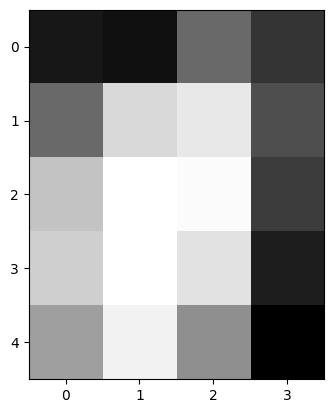

In [49]:
out_np = out_cancer.cpu().numpy()
print(out_np.shape)

print(out_np[0,:,:,1])

cancer_prob = (out_np[0,:,:,1]*255).astype(np.uint8)
#abnormal_prob = (out_np[0,:,:,1:].sum(axis=-1)*255).astype(np.uint8)
#normal_prob = (out_np[0,:,:,0:3].sum(axis=-1) * 255).astype(np.uint8)

plt.imshow(cancer_prob, cmap='gray')

In [50]:
print(out_np.shape)
out_np[0,:,:,1]


(1, 5, 4, 2)


array([[0.37080777, 0.34922123, 0.5887102 , 0.44941247],
       [0.5902799 , 0.8913122 , 0.9311364 , 0.517735  ],
       [0.8316514 , 0.9959578 , 0.98067963, 0.47395524],
       [0.8637327 , 0.9960659 , 0.9142737 , 0.3855575 ],
       [0.7336899 , 0.95926946, 0.691915  , 0.30912575]], dtype=float32)

In [51]:
out_features.shape

out_tokens = out_features.reshape(-1, out_features.shape[-1])

In [52]:
norms = np.linalg.norm(out_tokens, axis=-1)
print(norms)

normalized_tokens = out_tokens / norms[:, None]

[10.969888  22.036255  21.05451   19.734756   7.8419137 16.674654
 20.88529   23.653267  10.403237  29.746641  23.153736  23.490019
 11.207006  29.412046  19.111748  19.79625    7.7464304 24.258379
 16.935804  17.591684 ]


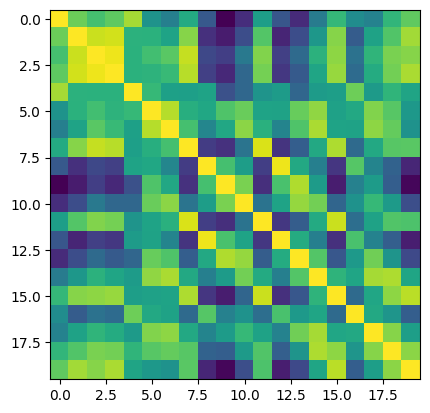

In [53]:
attn = np.matmul(normalized_tokens, normalized_tokens.T)
plt.imshow(attn)

[0.36862745 0.34901961 0.58823529 0.44705882 0.58823529 0.89019608
 0.92941176 0.51764706 0.83137255 0.99215686 0.98039216 0.47058824
 0.8627451  0.99215686 0.91372549 0.38431373 0.73333333 0.95686275
 0.69019608 0.30588235]
9 0.9921568627450981


Text(0.5, 1.0, 'Attention map for cancer token')

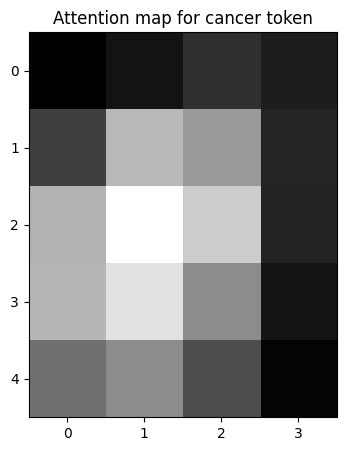

In [54]:


cancer_tokens = cancer_prob.reshape(-1)/255
print(cancer_tokens)

cancer_max_idx = np.argmax(cancer_tokens)
print(cancer_max_idx, cancer_tokens[cancer_max_idx])



fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(attn[cancer_max_idx].reshape(5,4), cmap='gray')
#ax[1].imshow(attn[9].reshape(5,4), cmap='gray')
ax.set_title("Attention map for cancer token")

[[0.00790713 0.0100937  0.02334673 0.01468297]
 [0.02702213 0.08283031 0.07519206 0.01839218]
 [0.07572128 0.11943513 0.09867381 0.01645022]
 [0.07932218 0.10772245 0.06921182 0.01131763]
 [0.04770529 0.07264279 0.03521387 0.00711623]]


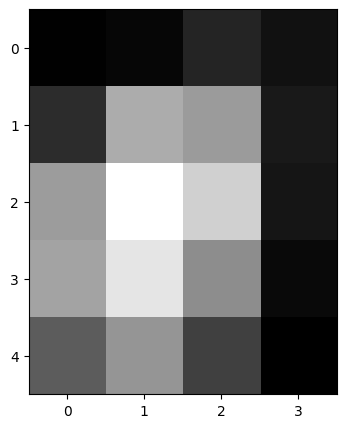

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(attn[cancer_max_idx].reshape(5,4) * cancer_prob / 255, cmap='gray')

M = attn[cancer_max_idx].reshape(5,4) * cancer_prob / 255
M = M / M.sum()
print(M)

In [21]:
from models.image_models import PatchFusionAttention

In [22]:
model[1].head.fc[1].in_features
    

1024

In [23]:
patch_fusion = PatchFusionAttention(1024)
patch_fusion.init_from_patchmodel(model)

In [24]:
res = patch_fusion(torch.from_numpy(out_features).unsqueeze(0))    

In [25]:
from models.model_selector import get_patch_model
import timm
import torch.nn as nn

model_name = 'swin_base_patch4_window7_224'
pretrained = False
num_classes = 6


# model = get_patch_model(model_name, num_classes=5, 
#                         pretrained=False, 
#                         trainable_gray2RGB=True,
#                     )

model = timm.create_model(model_name, pretrained=pretrained)
print(model.state_dict().keys())
model.head.fc = nn.Sequential(nn.Dropout(0.5),
    nn.Linear(model.head.fc.in_features, num_classes)
    )               

from models.modules import Gray2RGBadaptor
model = nn.Sequential(
    Gray2RGBadaptor(), 
    model)


#checkpoint_file = '/home/alalbiol/Programacion/Mammography/mamo_holistic/checkpoints/swin_base_x2_224_multilabel_CE_epoch=22-step=4025-val_auroc=0.919.ckpt'
#checkpoint_file = '/home/alalbiol/Programacion/Mammography/mamo_holistic/checkpoints/swin_base_x2_224_multilabel_mixup_0.8_CE_0.0_wd_0.2_dropout_0.5/swin_base_x2_224_CE_epoch=23-step=4200-val_auroc=0.927.ckpt'
checkpoint_file = "/home/alalbiol/Programacion/Mammography/mamo_holistic/checkpoints/swin_base_x2_224_cancerlabel_mixup_0.8_CE_0.0_wd_0.2_dropout_0.5/swin_base_x2_224_CE_epoch=28-step=5075-val_auroc=0.924.ckpt"


checkpoint = torch.load(checkpoint_file, map_location='cpu', weights_only=True)

new_state_dict = {key.replace("model.", ""): value for key, value in checkpoint['state_dict'].items()}


model.load_state_dict(new_state_dict)
print(new_state_dict.keys())
model[1].set_input_size((1120,896))

odict_keys(['patch_embed.proj.weight', 'patch_embed.proj.bias', 'patch_embed.norm.weight', 'patch_embed.norm.bias', 'layers.0.blocks.0.norm1.weight', 'layers.0.blocks.0.norm1.bias', 'layers.0.blocks.0.attn.relative_position_bias_table', 'layers.0.blocks.0.attn.qkv.weight', 'layers.0.blocks.0.attn.qkv.bias', 'layers.0.blocks.0.attn.proj.weight', 'layers.0.blocks.0.attn.proj.bias', 'layers.0.blocks.0.norm2.weight', 'layers.0.blocks.0.norm2.bias', 'layers.0.blocks.0.mlp.fc1.weight', 'layers.0.blocks.0.mlp.fc1.bias', 'layers.0.blocks.0.mlp.fc2.weight', 'layers.0.blocks.0.mlp.fc2.bias', 'layers.0.blocks.1.norm1.weight', 'layers.0.blocks.1.norm1.bias', 'layers.0.blocks.1.attn.relative_position_bias_table', 'layers.0.blocks.1.attn.qkv.weight', 'layers.0.blocks.1.attn.qkv.bias', 'layers.0.blocks.1.attn.proj.weight', 'layers.0.blocks.1.attn.proj.bias', 'layers.0.blocks.1.norm2.weight', 'layers.0.blocks.1.norm2.bias', 'layers.0.blocks.1.mlp.fc1.weight', 'layers.0.blocks.1.mlp.fc1.bias', 'layers.

In [89]:
from models.image_models import RelevantTokenSelector

relevant_token_selector = RelevantTokenSelector(1024, 20)
relevant_token_selector.init_scorer_from_patchmodel(model)

x = torch.randn(2,5,1024)

In [ ]:

relevant_token_selector.init_scorer_from_patchmodel(model)
relevant_token_selector.train()
y = relevant_token_selector(x)

print(y[0].shape)
print(y[1])

relevance_logits shape: torch.Size([2, 5])
relevance_logits: tensor([[ 0.3854, -0.4547, -0.2125,  0.6424, -0.7252],
        [ 0.2267, -0.9597,  0.2955,  0.6237,  0.5819]],
       grad_fn=<SqueezeBackward1>)
relevant probs tensor([[0.2775, 0.1198, 0.1526, 0.3588, 0.0914],
        [0.1890, 0.0577, 0.2025, 0.2812, 0.2696]], grad_fn=<SoftmaxBackward0>)
sampling categorical
torch.Size([2, 1024])
tensor([3, 0])


: 

In [39]:

relevant_token_selector.train()
res_emb, res_idx = relevant_token_selector(x)
print(res_idx)


tensor([1, 2])


In [94]:
# positional encoding for the tokens 4x5 pueden estar en el rango -3..3, -4..4
window_size_x = 3
window_size_y = 3

indices = torch.tensor(np.array([[y, x] for x in range(window_size_y) for y in range(window_size_x)]))

relative_positions = indices.unsqueeze(0) - indices.unsqueeze(1)

print(relative_positions.shape)
#print(relative_positions[:,:,0])
#print(relative_positions[:,:,1])

rel_x = relative_positions[:,:,0]
rel_y = relative_positions[:,:,1]


print(rel_x)
print(rel_y)

#create dict for relative positions


pos_dict = {}

relative_indexes = []

for pos in (relative_positions.reshape(-1,2)):
    pos = (pos[0].item(), pos[1].item())
    print(pos)
    if not pos in pos_dict:
        pos_dict[pos] = len(pos_dict)
    
    relative_indexes.append(pos_dict[pos])
        
relative_indexes = np.array(relative_indexes)
print(relative_indexes.reshape(window_size_y*window_size_x, window_size_y*window_size_x))   
    
print(relative_indexes)






torch.Size([9, 9, 2])
tensor([[ 0,  1,  2,  0,  1,  2,  0,  1,  2],
        [-1,  0,  1, -1,  0,  1, -1,  0,  1],
        [-2, -1,  0, -2, -1,  0, -2, -1,  0],
        [ 0,  1,  2,  0,  1,  2,  0,  1,  2],
        [-1,  0,  1, -1,  0,  1, -1,  0,  1],
        [-2, -1,  0, -2, -1,  0, -2, -1,  0],
        [ 0,  1,  2,  0,  1,  2,  0,  1,  2],
        [-1,  0,  1, -1,  0,  1, -1,  0,  1],
        [-2, -1,  0, -2, -1,  0, -2, -1,  0]])
tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2],
        [ 0,  0,  0,  1,  1,  1,  2,  2,  2],
        [ 0,  0,  0,  1,  1,  1,  2,  2,  2],
        [-1, -1, -1,  0,  0,  0,  1,  1,  1],
        [-1, -1, -1,  0,  0,  0,  1,  1,  1],
        [-1, -1, -1,  0,  0,  0,  1,  1,  1],
        [-2, -2, -2, -1, -1, -1,  0,  0,  0],
        [-2, -2, -2, -1, -1, -1,  0,  0,  0],
        [-2, -2, -2, -1, -1, -1,  0,  0,  0]])
(0, 0)
(1, 0)
(2, 0)
(0, 1)
(1, 1)
(2, 1)
(0, 2)
(1, 2)
(2, 2)
(-1, 0)
(0, 0)
(1, 0)
(-1, 1)
(0, 1)
(1, 1)
(-1, 2)
(0, 2)
(1, 2)
(-2, 0)
(-1, 0)
(0,

In [ ]:
class RelevantTokenAttention(nn.Module):
    def __init__(self, window_size_x, window_size_y, qv_dim = 256, token_dim = 1024):
        super().__init__()
        self.create_positional_biases(window_size_x, window_size_y)
        self.token_selector = RelevantTokenSelector(token_dim, window_size_x*window_size_y)
        self.kv = nn.Linear(token_dim, qv_dim)
        self.layer_norm = nn.LayerNorm(token_dim)
        self.create_positional_biases(window_size_x, window_size_y)
        
    def create_positional_biases(self, window_size_x, window_size_y):
        mesh = np.meshgrid(range(window_size_x), range(window_size_y))

        indices = np.array([np.array([x,y]) for x,y in zip(mesh[0].flatten(), mesh[1].flatten())])

        pos_dict = {}
        relative_positions = indices[np.newaxis,:] - indices[:,np.newaxis]
        relative_indexes = []
        print(relative_positions.shape)
        for pos in (relative_positions.reshape(-1,2)):
            pos = (pos[0], pos[1])

            if not pos in pos_dict:
                pos_dict[pos] = len(pos_dict)
            
            relative_indexes.append(pos_dict[pos])
                
        relative_indexes = np.array(relative_indexes).reshape(window_size_y*window_size_x, window_size_y*window_size_x)
        #print(relative_indexes)   
        self.unique_bias_param = nn.Parameter(torch.zeros(len(pos_dict)))
        self.bias_param = self.unique_bias_param[relative_indexes]
        
  
    def forward(self, x):
        # x B x N x token_dim
        selected_token, selected_idx = self.token_selector(x) # B x token_dim, B 
        
        xnorm = self.layer_norm(x)
        
        key = self.kv(xnorm) # B x N x qv_dim
        query = self.kv(self.layer_norm(selected_token)) # B x  qv_dim
        
        attn = torch.einsum('bd,bnd->bn', query, key) / np.sqrt(key.shape[-1])   # B x N
        
        bias = self.bias_param[ selected_idx, :] # B x N
        
        attn = attn + bias
        
        attn = torch.softmax(attn, dim=-1)
        y = torch.einsum('bn,bnd->bd', attn, xnorm) # B x token_dim
    
        
        y = self.layer_norm(y + selected_token)
        return y
         

In [ ]:
fa = RelevantTokenAttention(4,5)

x = torch.randn(2,20,1024)

fa.bias_param[torch.arange(10), torch.randint(0, 20, (10,))]

y = fa(x)

print("y shape", y.shape)



(20, 20, 2)
torch.Size([2, 1024])
torch.Size([2])
bias param torch.Size([20, 20])
attn shape torch.Size([2, 20])
selected_idx shape torch.Size([2])
tensor([0, 1])
tensor([16, 13])
torch.Size([2, 20])
torch.Size([2, 1024])
torch.Size([2, 20, 1024])
y shape torch.Size([2, 1024])


: 